In [ ]:
# this file is for pruning model

In [23]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import models
from models import channel_selection
import torchvision
from matplotlib import pyplot as plt

In [24]:
#load the baseline model and parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet()
print(device)

model = model.to(device)

path = './checkpoint/baseline/baseline_model_best.pth.tar'
print("=> loading checkpoint '{}'".format(path))
checkpoint = torch.load(path,map_location=device)

start_epoch = checkpoint['epoch']
#print(start_epoch)

best_prec1 = checkpoint['best_prec1']
#print(best_prec1)

model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}".format(path, checkpoint['epoch'], best_prec1))



cuda
=> loading checkpoint './checkpoint/baseline/baseline_model_best.pth.tar'
=> loaded checkpoint './checkpoint/baseline/baseline_model_best.pth.tar' (epoch 122) Prec1: 0.937800


In [25]:
total = 0
percent = 0.45 # eliminating channel ratio

#count number of BN channels
for name,m in model.named_modules():
    if isinstance(m, nn.BatchNorm2d) and 'fusion' not in name:
        total += m.weight.data.shape[0]

print(total)
# store weight value of BN layer
bn = torch.zeros(total)
index = 0
for name,m in model.named_modules():
    if isinstance(m, nn.BatchNorm2d) and 'fusion' not in name:
        size = m.weight.data.shape[0]
        bn[index:(index+size)] = m.weight.data.abs().clone()
        index += size

# sort all value
y, i = torch.sort(bn)
thre_index = int(total * percent)

# pick the threshold
thre = y[thre_index]
print(thre)

3200
tensor(0.0880)


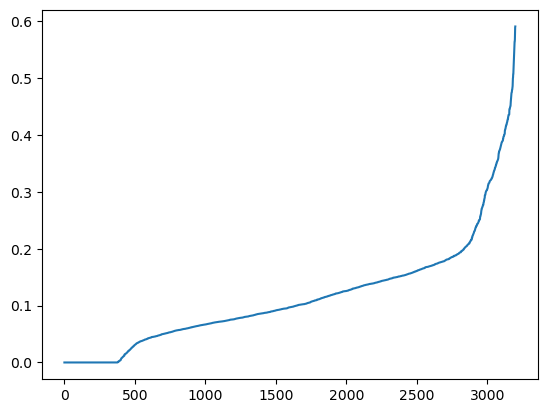

In [26]:
# plot the curve of distribution
plt.plot(y)
plt.savefig("./checkpoint/channel_factor_distribution.png")

In [27]:
# get the channel mask
# for useless channel we set 0 other set 1
pruned = 0
cfg = []
cfg_mask = []


for k, (name,m) in enumerate(model.named_modules()):
    if isinstance(m, nn.BatchNorm2d) and 'fusion' not in name:
        weight_copy = m.weight.data.abs().clone()
        # if greater than threshold
        mask = weight_copy.gt(thre).float().to(device)

        #count the number of channel been pruned
        pruned = pruned + mask.shape[0] - torch.sum(mask)

        # set insignificant channel to 0
        m.weight.data.mul_(mask)
        m.bias.data.mul_(mask)

        # count the number of channel still in use
        cfg.append(int(torch.sum(mask)))
        cfg_mask.append(mask.clone())

        print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.format(k, mask.shape[0], int(torch.sum(mask))))

    elif isinstance(m, nn.MaxPool2d):
        cfg.append('M')

pruned_ratio = pruned/total

print('Pre-processing Successful!')

layer index: 80 	 total channel: 128 	 remaining channel: 123
layer index: 83 	 total channel: 256 	 remaining channel: 255
layer index: 89 	 total channel: 256 	 remaining channel: 220
layer index: 92 	 total channel: 256 	 remaining channel: 254
layer index: 97 	 total channel: 256 	 remaining channel: 199
layer index: 100 	 total channel: 512 	 remaining channel: 167
layer index: 106 	 total channel: 512 	 remaining channel: 68
layer index: 109 	 total channel: 512 	 remaining channel: 144
layer index: 112 	 total channel: 512 	 remaining channel: 329
Pre-processing Successful!


In [28]:
# simple test model after Pre-processing prune (simple set BN scales to zeros)
def test(model):
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')
        
    model.eval()
    correct = 0
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    print('\nTest set: Accuracy: {}/{} ({:.1f}%)\n'.format(
        correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset))

acc = test(model)

Files already downloaded and verified

Test set: Accuracy: 8172/10000 (81.7%)



In [29]:
# build new model from modified cfg configuration file
newmodel = models.resnet(cfg=cfg)

newmodel = newmodel.to(device)

num_parameters = sum([param.nelement() for param in newmodel.parameters()])
print(num_parameters)

savepath = os.path.join('./checkpoint/prune', "prune.txt")
with open(savepath, "w") as fp:
    fp.write("Configuration: \n"+str(cfg)+"\n")
    fp.write("Number of parameters: \n"+str(num_parameters)+"\n")
    fp.write("Test accuracy: \n"+str(acc))

4558938


In [30]:
# load the parameter from old model to new model
old_modules = list(model.named_modules())
new_modules = list(newmodel.named_modules())

layer_id_in_cfg = 0

start_mask = torch.ones(2)
end_mask = cfg_mask[layer_id_in_cfg]

conv_count = 0

for layer_id in range(len(old_modules)):
    
    name_0 = old_modules[layer_id][0]
    m0 = old_modules[layer_id][1]
    name_1 = new_modules[layer_id][0]
    m1 = new_modules[layer_id][1]
    
    
    if 'fusion' in name_0:
        continue
    
    #bn layer
    if isinstance(m0, nn.BatchNorm2d):
        
        # index of positive value
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))

        if idx1.size == 1:
            idx1 = np.resize(idx1,(1,))

        if isinstance(old_modules[layer_id + 1][1], channel_selection):
            # If the next layer is the channel selection layer, 
            # then the current batchnorm 2d layer won't be pruned.
            
            m1.weight.data = m0.weight.data.clone()
            m1.bias.data = m0.bias.data.clone()
            m1.running_mean = m0.running_mean.clone()
            m1.running_var = m0.running_var.clone()

            # We need to set the channel selection layer.
            m2 = new_modules[layer_id + 1][1]
            m2.indexes.data.zero_()
            m2.indexes.data[idx1.tolist()] = 1.0

            layer_id_in_cfg += 1
            start_mask = end_mask.clone()

            if layer_id_in_cfg < len(cfg_mask):
                end_mask = cfg_mask[layer_id_in_cfg]
        else:
            m1.weight.data = m0.weight.data[idx1.tolist()].clone()
            m1.bias.data = m0.bias.data[idx1.tolist()].clone()
            m1.running_mean = m0.running_mean[idx1.tolist()].clone()
            m1.running_var = m0.running_var[idx1.tolist()].clone()

            layer_id_in_cfg += 1
            start_mask = end_mask.clone()

            # do not change in Final FC
            if layer_id_in_cfg < len(cfg_mask):  
                end_mask = cfg_mask[layer_id_in_cfg]
            
# conv layer          
    elif isinstance(m0, nn.Conv2d):
        if conv_count == 0:
            m1.weight.data = m0.weight.data.clone()
            conv_count += 1
            continue
        if isinstance(old_modules[layer_id-1][1], channel_selection) or isinstance(old_modules[layer_id-1][1], nn.BatchNorm2d):
            # This convers the convolutions in the residual block.
            # The convolutions are either after the channel selection layer or after the batch normalization layer.
            conv_count += 1
            
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            
            print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
            
            if idx0.size == 1:
                idx0 = np.resize(idx0, (1,))
            if idx1.size == 1:
                idx1 = np.resize(idx1, (1,))
                
            w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()

            # If the current convolution is not the last convolution in the residual block, then we can change the 
            # number of output channels. Currently we use `conv_count` to detect whether it is such convolution.
            if conv_count % 2 != 1:
                w1 = w1[idx1.tolist(), :, :, :].clone()
                
            m1.weight.data = w1.clone()
            continue

        # We need to consider the case where there are downsampling convolutions. 
        # For these convolutions, we just copy the weights.
        m1.weight.data = m0.weight.data.clone()
    elif isinstance(m0, nn.Linear):
        idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
        if idx0.size == 1:
            idx0 = np.resize(idx0, (1,))

        m1.weight.data = m0.weight.data[:, idx0].clone()
        m1.bias.data = m0.bias.data.clone()





In shape: 123, Out shape 255.
In shape: 255, Out shape 220.
In shape: 220, Out shape 254.
In shape: 254, Out shape 199.
In shape: 199, Out shape 167.
In shape: 167, Out shape 68.
In shape: 68, Out shape 144.
In shape: 144, Out shape 329.


In [31]:
print(newmodel)
torch.save({'cfg': cfg, 'state_dict': newmodel.state_dict()}, os.path.join('./checkpoint/prune', 'pruned.pth.tar'))

resnet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fusion_layer1): Sequential(
    (0): FusionBlock(
      (conv1): Sequential(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
          (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Sequential(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
          (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1)
      )
      (bn2): Batch

In [ ]:
model = newmodel
test(model)